In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array


In [4]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
_img = []
path = '/content/drive/MyDrive/GAN/dataset'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
        if i == 'seed9090.png':
            break
        else:    
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = (img - 127.5) / 127.5
            imh = img.astype(float)
            _img.append(img_to_array(img))


100%|██████████| 110/110 [02:09<00:00,  1.18s/it]


In [5]:
print(len(_img))#. .shape)

110


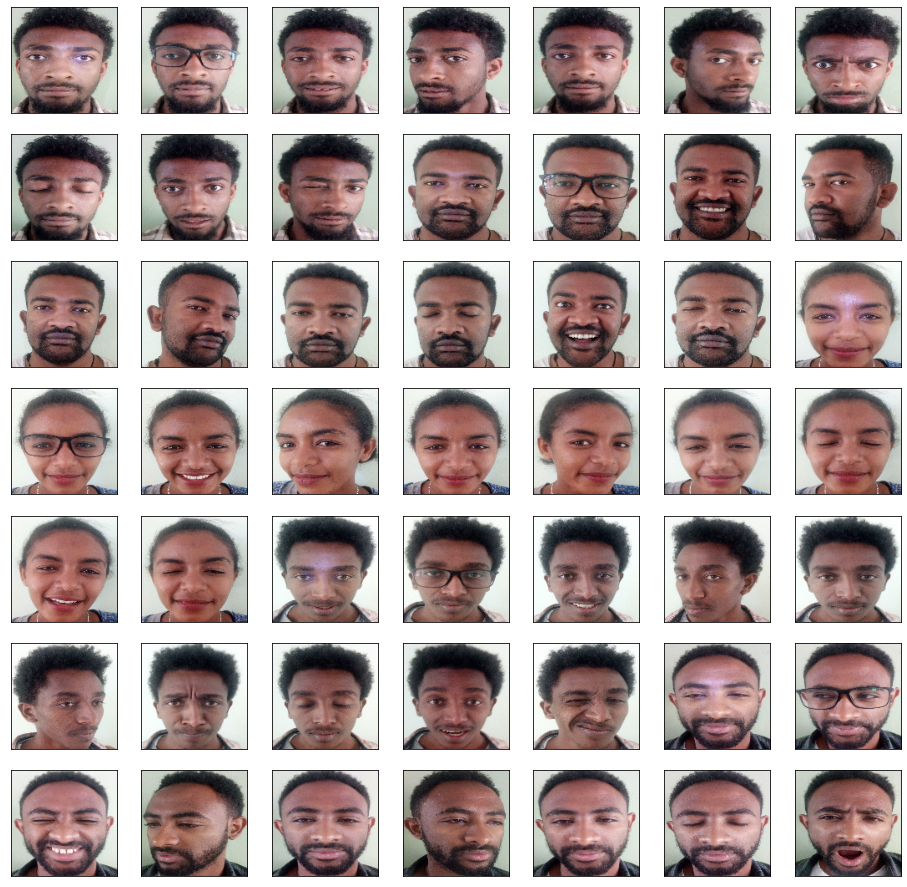

In [6]:
def plot_images(sqr = 4):
    plt.figure(figsize = (16,16))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr*sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])
# to plot images
plot_images(7)

In [7]:
batch_size = 16
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)
print(len(dataset))#.shape)

7


In [8]:
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128,128,3)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
  
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))
    return model

In [9]:
generator = Generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 49152)             4915200   
_________________________________________________________________
reshape (Reshape)            (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 128)       6144      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       524288    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 256)       1

In [10]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model

In [11]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 128)       6144      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       524288    
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 256)       1024      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 512)      

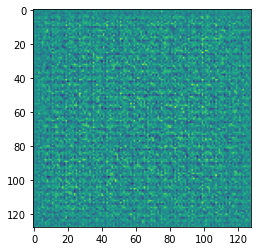

In [12]:
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

In [13]:
optimizer = tf.keras.optimizers.RMSprop(lr=.0001,clipvalue=1.0,decay=1e-8)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

In [15]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

In [16]:
from PIL import Image
import matplotlib
dim=(400,400)
def plot_generated_images(square =5, epochs=0):   
  plt.figure(figsize = (10,10))
  for i in range(square * square):
    if(i == square //2):
        plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 22, color = 'red')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    # path="/content/drive/MyDrive/GAN/Generated_Image"
    # img = Image.fromarray(img, 'RGB')
    image=np.clip((img[0,...]+1)/2, 0, 1)
    # img = Image.fromarray(img, 'RGB')
    # print(image.shape)
    im_resized=cv2.resize(image,dim,interpolation = cv2.INTER_AREA)
    matplotlib.image.imsave('/content/drive/MyDrive/GAN/Generated_Image/generated_{}.jpg'.format(i), im_resized)
    plt.imshow(image)#np.clip((img[0,...]+1)/2, 0, 1))
    plt.xticks([])
    plt.yticks([])
    plt.grid()
  
  print(img.shape)
# imag = Image.fromarray(image, 'RGB')
# imag.save('/content/drive/MyDrive/GAN/Generated_Image/my.png')

In [17]:
import time
def train(epochs,dataset):
    for epoch in range(epochs):
        start = time.time()
        for images in dataset:
            train_steps(images)
        print("Epoch:{} Time:{}".format(epoch+1,np.round(time.time() - start),2))  
    plot_generated_images(5,epoch+1)

In [ ]:
train(15000,dataset)

Epoch:1 Time:6.0
Epoch:2 Time:3.0
Epoch:3 Time:3.0
Epoch:4 Time:3.0
Epoch:5 Time:3.0
Epoch:6 Time:3.0
Epoch:7 Time:3.0
Epoch:8 Time:3.0
Epoch:9 Time:3.0
Epoch:10 Time:3.0
Epoch:11 Time:3.0
Epoch:12 Time:3.0
Epoch:13 Time:3.0
Epoch:14 Time:3.0
Epoch:15 Time:3.0
Epoch:16 Time:3.0
Epoch:17 Time:3.0
Epoch:18 Time:3.0
Epoch:19 Time:3.0
Epoch:20 Time:3.0
Epoch:21 Time:3.0
Epoch:22 Time:3.0
Epoch:23 Time:3.0
Epoch:24 Time:3.0
Epoch:25 Time:3.0
Epoch:26 Time:3.0
Epoch:27 Time:3.0
Epoch:28 Time:3.0
Epoch:29 Time:3.0
Epoch:30 Time:3.0
Epoch:31 Time:3.0
Epoch:32 Time:3.0
Epoch:33 Time:3.0
Epoch:34 Time:3.0
Epoch:35 Time:3.0
Epoch:36 Time:3.0
Epoch:37 Time:3.0
Epoch:38 Time:3.0
Epoch:39 Time:3.0
Epoch:40 Time:3.0
Epoch:41 Time:3.0
Epoch:42 Time:3.0
Epoch:43 Time:3.0
Epoch:44 Time:3.0
Epoch:45 Time:3.0
Epoch:46 Time:3.0
Epoch:47 Time:3.0
Epoch:48 Time:3.0
Epoch:49 Time:3.0
Epoch:50 Time:3.0
Epoch:51 Time:3.0
Epoch:52 Time:3.0
Epoch:53 Time:3.0
Epoch:54 Time:3.0
Epoch:55 Time:3.0
Epoch:56 Time:3.0
E

In [ ]:
# plot_generated_images(10,500)

In [ ]:
# from matplotlib import pyplot
# def save_plot(n=7,epoch=0):
#   # scale from [-1,1] to [0,1]
#   noise = np.random.normal(0,1,(1,latent_dim))
#   examples = generator(noise)
#   examples = (examples + 1) / 2.0
#   # plot images
#   for i in range(n * n):
#     # define subplot
#     pyplot.subplot(n, n, 1 + i)
#     # turn off axis
#     pyplot.axis('off')
#     # plot raw pixel data
#     pyplot.imshow(examples[i])
#   # save plot to file
#   filename = '/content/drive/MyDrive/GAN/Generated_Image/generated_plot_e%03d.png' % (epoch+1)
#   pyplot.savefig(filename)
#   pyplot.close()

In [ ]:
# def save_imgs(generator, epoch):
#     r, c = 5, 5
#     # noise = np.random.normal(0, 1, (r * c, 100))
#     gen_imgs = generator.predict(noise)
#     gen_imgs = 0.5 * gen_imgs + 0.5
#     # fig, axs = plt.subplots(r, c)
#     cnt = 0
#     for i in range(r):
#       for j in range(c):
#         axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
#         axs[i, j].axis('off')
#         cnt += 1
#     fig.savefig("/content/drive/MyDrive/GAN/Generated_Image/generated_plot_{}.jpg" %epoch)#), batch))
#     plt.close()
# save_imgs(generator,50)

In [ ]:
# generator.save('/content/drive/MyDrive/GAN/generator_20000.h5')
# discriminator.save("/content/drive/MyDrive/GAN/discriminator_20000.h5")